# Poetry Generation

In [2]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU

Using TensorFlow backend.


In [11]:
# configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [5]:
# load in the data
input_texts = []
target_texts = []
for line in open('/home/shadaab17/Desktop/Udemy/Deep Learning Advanced NLP/Class Notes/Seq2Seq/Poetry generation/robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue

  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)


all_lines = input_texts + target_texts


In [6]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [7]:
# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

Max sequence length: 12


In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


In [9]:
# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


In [12]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [13]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [14]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1

In [15]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)

In [16]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

Building model...
Instructions for updating:
Colocations handled automatically by placer.


In [17]:
print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1148 samples, validate on 288 samples
Epoch 1/2000
 256/1148 [=====>........................] - ETA: 30s - loss: 5.6055 - acc: 0.0410     

/home/shadaab17/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.319247). Check your callbacks.
  % delta_t_median)


1148/1148 [==============================] - 15s 13ms/step - loss: 5.3403 - acc: 0.0739 - val_loss: 4.9782 - val_acc: 0.0833
Epoch 2/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 4.5544 - acc: 0.0833 - val_loss: 4.7884 - val_acc: 0.0833
Epoch 3/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 4.3570 - acc: 0.0833 - val_loss: 4.9194 - val_acc: 0.0833
Epoch 4/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 4.3228 - acc: 0.0833 - val_loss: 4.9394 - val_acc: 0.0833
Epoch 5/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 4.2948 - acc: 0.0833 - val_loss: 4.9726 - val_acc: 0.0833
Epoch 6/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 4.2807 - acc: 0.0833 - val_loss: 4.9999 - val_acc: 0.0833
Epoch 7/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 4.2714 - acc: 0.0833 - val_loss: 5.0089 - val_acc: 0.0833
Epoch 8/2000
1148/1148 [==============================] - 3

Epoch 61/2000
1148/1148 [==============================] - 5s 4ms/step - loss: 3.0495 - acc: 0.1733 - val_loss: 5.1176 - val_acc: 0.0946
Epoch 62/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 3.0261 - acc: 0.1752 - val_loss: 5.1287 - val_acc: 0.0932
Epoch 63/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 3.0000 - acc: 0.1769 - val_loss: 5.1365 - val_acc: 0.0946
Epoch 64/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 2.9764 - acc: 0.1797 - val_loss: 5.1568 - val_acc: 0.0938
Epoch 65/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 2.9537 - acc: 0.1811 - val_loss: 5.1545 - val_acc: 0.0935
Epoch 66/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.9324 - acc: 0.1831 - val_loss: 5.1640 - val_acc: 0.0938
Epoch 67/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.9095 - acc: 0.1842 - val_loss: 5.1584 - val_acc: 0.0935
Epoch 68/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 2.1668 - acc: 0.2697 - val_loss: 5.5999 - val_acc: 0.0802
Epoch 121/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.1583 - acc: 0.2708 - val_loss: 5.6094 - val_acc: 0.0810
Epoch 122/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.1503 - acc: 0.2736 - val_loss: 5.6169 - val_acc: 0.0802
Epoch 123/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.1420 - acc: 0.2748 - val_loss: 5.6223 - val_acc: 0.0819
Epoch 124/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.1361 - acc: 0.2750 - val_loss: 5.6214 - val_acc: 0.0816
Epoch 125/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.1297 - acc: 0.2773 - val_loss: 5.6418 - val_acc: 0.0810
Epoch 126/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.1222 - acc: 0.2764 - val_loss: 5.6375 - val_acc: 0.0810
Epoch 127/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.8227 - acc: 0.3190 - val_loss: 5.9934 - val_acc: 0.0677
Epoch 180/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.8168 - acc: 0.3193 - val_loss: 5.9967 - val_acc: 0.0674
Epoch 181/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.8144 - acc: 0.3203 - val_loss: 6.0087 - val_acc: 0.0668
Epoch 182/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.8102 - acc: 0.3200 - val_loss: 6.0142 - val_acc: 0.0677
Epoch 183/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.8070 - acc: 0.3214 - val_loss: 6.0183 - val_acc: 0.0692
Epoch 184/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.8027 - acc: 0.3224 - val_loss: 6.0343 - val_acc: 0.0677
Epoch 185/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.8039 - acc: 0.3207 - val_loss: 6.0242 - val_acc: 0.0668
Epoch 186/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.6225 - acc: 0.3523 - val_loss: 6.3091 - val_acc: 0.0613
Epoch 239/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.6190 - acc: 0.3526 - val_loss: 6.3134 - val_acc: 0.0608
Epoch 240/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.6154 - acc: 0.3530 - val_loss: 6.3277 - val_acc: 0.0608
Epoch 241/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.6119 - acc: 0.3522 - val_loss: 6.3310 - val_acc: 0.0608
Epoch 242/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.6099 - acc: 0.3542 - val_loss: 6.3175 - val_acc: 0.0602
Epoch 243/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.6073 - acc: 0.3539 - val_loss: 6.3396 - val_acc: 0.0605
Epoch 244/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.6049 - acc: 0.3545 - val_loss: 6.3324 - val_acc: 0.0611
Epoch 245/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.4776 - acc: 0.3788 - val_loss: 6.5688 - val_acc: 0.0593
Epoch 298/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.4799 - acc: 0.3788 - val_loss: 6.5710 - val_acc: 0.0584
Epoch 299/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.4769 - acc: 0.3782 - val_loss: 6.5920 - val_acc: 0.0567
Epoch 300/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.4753 - acc: 0.3799 - val_loss: 6.5965 - val_acc: 0.0576
Epoch 301/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.4712 - acc: 0.3811 - val_loss: 6.5746 - val_acc: 0.0579
Epoch 302/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.4705 - acc: 0.3813 - val_loss: 6.5974 - val_acc: 0.0567
Epoch 303/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.4662 - acc: 0.3838 - val_loss: 6.5910 - val_acc: 0.0587
Epoch 304/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.3586 - acc: 0.4036 - val_loss: 6.7983 - val_acc: 0.0524
Epoch 357/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3581 - acc: 0.4045 - val_loss: 6.8044 - val_acc: 0.0547
Epoch 358/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3580 - acc: 0.4048 - val_loss: 6.7962 - val_acc: 0.0541
Epoch 359/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3568 - acc: 0.4045 - val_loss: 6.8111 - val_acc: 0.0541
Epoch 360/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3528 - acc: 0.4068 - val_loss: 6.8123 - val_acc: 0.0541
Epoch 361/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3504 - acc: 0.4054 - val_loss: 6.8223 - val_acc: 0.0558
Epoch 362/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3495 - acc: 0.4044 - val_loss: 6.8146 - val_acc: 0.0556
Epoch 363/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.2693 - acc: 0.4219 - val_loss: 7.0335 - val_acc: 0.0492
Epoch 416/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2699 - acc: 0.4228 - val_loss: 7.0281 - val_acc: 0.0527
Epoch 417/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2698 - acc: 0.4215 - val_loss: 7.0379 - val_acc: 0.0498
Epoch 418/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2702 - acc: 0.4220 - val_loss: 7.0346 - val_acc: 0.0512
Epoch 419/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2736 - acc: 0.4197 - val_loss: 7.0322 - val_acc: 0.0518
Epoch 420/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2772 - acc: 0.4182 - val_loss: 7.0272 - val_acc: 0.0518
Epoch 421/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2761 - acc: 0.4180 - val_loss: 7.0442 - val_acc: 0.0498
Epoch 422/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.2101 - acc: 0.4326 - val_loss: 7.2097 - val_acc: 0.0483
Epoch 475/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2086 - acc: 0.4323 - val_loss: 7.2084 - val_acc: 0.0460
Epoch 476/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2095 - acc: 0.4307 - val_loss: 7.2143 - val_acc: 0.0477
Epoch 477/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2116 - acc: 0.4314 - val_loss: 7.2072 - val_acc: 0.0480
Epoch 478/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2124 - acc: 0.4317 - val_loss: 7.2072 - val_acc: 0.0477
Epoch 479/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2094 - acc: 0.4311 - val_loss: 7.2219 - val_acc: 0.0469
Epoch 480/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2088 - acc: 0.4329 - val_loss: 7.2062 - val_acc: 0.0483
Epoch 481/2000
1148/1148 [=======================

1148/1148 [==============================] - 4s 3ms/step - loss: 1.1755 - acc: 0.4378 - val_loss: 7.3038 - val_acc: 0.0477
Epoch 534/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.1709 - acc: 0.4395 - val_loss: 7.3135 - val_acc: 0.0498
Epoch 535/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1677 - acc: 0.4400 - val_loss: 7.3095 - val_acc: 0.0480
Epoch 536/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.1665 - acc: 0.4393 - val_loss: 7.3356 - val_acc: 0.0477
Epoch 537/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1696 - acc: 0.4410 - val_loss: 7.3263 - val_acc: 0.0480
Epoch 538/2000
1148/1148 [==============================] - 4s 4ms/step - loss: 1.1726 - acc: 0.4388 - val_loss: 7.3187 - val_acc: 0.0501
Epoch 539/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.1700 - acc: 0.4416 - val_loss: 7.3288 - val_acc: 0.0480
Epoch 540/2000
1148/1148 [=======================

1148/1148 [==============================] - 4s 3ms/step - loss: 1.1069 - acc: 0.4560 - val_loss: 7.4851 - val_acc: 0.0437
Epoch 593/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1029 - acc: 0.4566 - val_loss: 7.4737 - val_acc: 0.0448
Epoch 594/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1041 - acc: 0.4571 - val_loss: 7.4845 - val_acc: 0.0443
Epoch 595/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1047 - acc: 0.4544 - val_loss: 7.4727 - val_acc: 0.0451
Epoch 596/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.1056 - acc: 0.4560 - val_loss: 7.4932 - val_acc: 0.0417
Epoch 597/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.1051 - acc: 0.4564 - val_loss: 7.4832 - val_acc: 0.0428
Epoch 598/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.1043 - acc: 0.4554 - val_loss: 7.4927 - val_acc: 0.0451
Epoch 599/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 3ms/step - loss: 1.0754 - acc: 0.4623 - val_loss: 7.5832 - val_acc: 0.0434
Epoch 652/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0728 - acc: 0.4609 - val_loss: 7.5822 - val_acc: 0.0422
Epoch 653/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0713 - acc: 0.4616 - val_loss: 7.5959 - val_acc: 0.0443
Epoch 654/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0720 - acc: 0.4618 - val_loss: 7.5936 - val_acc: 0.0417
Epoch 655/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.0701 - acc: 0.4612 - val_loss: 7.6098 - val_acc: 0.0443
Epoch 656/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.0659 - acc: 0.4632 - val_loss: 7.6003 - val_acc: 0.0451
Epoch 657/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.0703 - acc: 0.4623 - val_loss: 7.6046 - val_acc: 0.0457
Epoch 658/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.0545 - acc: 0.4637 - val_loss: 7.6409 - val_acc: 0.0425
Epoch 711/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0526 - acc: 0.4631 - val_loss: 7.6448 - val_acc: 0.0425
Epoch 712/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0503 - acc: 0.4646 - val_loss: 7.6479 - val_acc: 0.0428
Epoch 713/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0502 - acc: 0.4641 - val_loss: 7.6596 - val_acc: 0.0405
Epoch 714/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0490 - acc: 0.4641 - val_loss: 7.6496 - val_acc: 0.0431
Epoch 715/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.0459 - acc: 0.4652 - val_loss: 7.6604 - val_acc: 0.0434
Epoch 716/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0464 - acc: 0.4656 - val_loss: 7.6651 - val_acc: 0.0402
Epoch 717/2000
1148/1148 [=======================

1148/1148 [==============================] - 5s 4ms/step - loss: 1.0201 - acc: 0.4719 - val_loss: 7.7706 - val_acc: 0.0420
Epoch 770/2000
1148/1148 [==============================] - 4s 4ms/step - loss: 1.0184 - acc: 0.4734 - val_loss: 7.7650 - val_acc: 0.0425
Epoch 771/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 1.0179 - acc: 0.4731 - val_loss: 7.7490 - val_acc: 0.0440
Epoch 772/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0169 - acc: 0.4734 - val_loss: 7.7659 - val_acc: 0.0434
Epoch 773/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0162 - acc: 0.4726 - val_loss: 7.7613 - val_acc: 0.0446
Epoch 774/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0184 - acc: 0.4726 - val_loss: 7.7846 - val_acc: 0.0428
Epoch 775/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.0162 - acc: 0.4711 - val_loss: 7.7620 - val_acc: 0.0422
Epoch 776/2000
1148/1148 [=======================

1148/1148 [==============================] - 4s 4ms/step - loss: 1.0057 - acc: 0.4748 - val_loss: 7.8713 - val_acc: 0.0391
Epoch 829/2000
1148/1148 [==============================] - 4s 4ms/step - loss: 1.0038 - acc: 0.4748 - val_loss: 7.8612 - val_acc: 0.0411
Epoch 830/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 1.0007 - acc: 0.4765 - val_loss: 7.8466 - val_acc: 0.0394
Epoch 831/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9965 - acc: 0.4773 - val_loss: 7.8608 - val_acc: 0.0405
Epoch 832/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9940 - acc: 0.4788 - val_loss: 7.8388 - val_acc: 0.0417
Epoch 833/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9936 - acc: 0.4784 - val_loss: 7.8548 - val_acc: 0.0431
Epoch 834/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9903 - acc: 0.4806 - val_loss: 7.8568 - val_acc: 0.0391
Epoch 835/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 3ms/step - loss: 0.9841 - acc: 0.4817 - val_loss: 7.9052 - val_acc: 0.0396
Epoch 888/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9924 - acc: 0.4778 - val_loss: 7.9458 - val_acc: 0.0414
Epoch 889/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9910 - acc: 0.4779 - val_loss: 7.9279 - val_acc: 0.0414
Epoch 890/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9903 - acc: 0.4794 - val_loss: 7.9382 - val_acc: 0.0414
Epoch 891/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9860 - acc: 0.4779 - val_loss: 7.9195 - val_acc: 0.0414
Epoch 892/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9822 - acc: 0.4816 - val_loss: 7.9317 - val_acc: 0.0408
Epoch 893/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9820 - acc: 0.4811 - val_loss: 7.9347 - val_acc: 0.0425
Epoch 894/2000
1148/1148 [=======================

1148/1148 [==============================] - 5s 4ms/step - loss: 0.9598 - acc: 0.4860 - val_loss: 7.9852 - val_acc: 0.0422
Epoch 947/2000
1148/1148 [==============================] - 5s 4ms/step - loss: 0.9671 - acc: 0.4849 - val_loss: 7.9985 - val_acc: 0.0425
Epoch 948/2000
1148/1148 [==============================] - 4s 4ms/step - loss: 0.9616 - acc: 0.4864 - val_loss: 8.0052 - val_acc: 0.0394
Epoch 949/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9689 - acc: 0.4848 - val_loss: 8.0201 - val_acc: 0.0434
Epoch 950/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9668 - acc: 0.4854 - val_loss: 7.9976 - val_acc: 0.0414
Epoch 951/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9653 - acc: 0.4852 - val_loss: 8.0166 - val_acc: 0.0396
Epoch 952/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9648 - acc: 0.4831 - val_loss: 7.9808 - val_acc: 0.0411
Epoch 953/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.9242 - acc: 0.4951 - val_loss: 8.0752 - val_acc: 0.0411
Epoch 1006/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9218 - acc: 0.4954 - val_loss: 8.0515 - val_acc: 0.0414
Epoch 1007/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9237 - acc: 0.4959 - val_loss: 8.0719 - val_acc: 0.0420
Epoch 1008/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9228 - acc: 0.4975 - val_loss: 8.0570 - val_acc: 0.0414
Epoch 1009/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9241 - acc: 0.4932 - val_loss: 8.0829 - val_acc: 0.0399
Epoch 1010/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9268 - acc: 0.4949 - val_loss: 8.0793 - val_acc: 0.0411
Epoch 1011/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9256 - acc: 0.4946 - val_loss: 8.0949 - val_acc: 0.0391
Epoch 1012/2000
1148/1148 [================

1148/1148 [==============================] - 3s 3ms/step - loss: 0.9361 - acc: 0.4901 - val_loss: 8.0960 - val_acc: 0.0396
Epoch 1065/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9314 - acc: 0.4911 - val_loss: 8.1166 - val_acc: 0.0414
Epoch 1066/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9337 - acc: 0.4928 - val_loss: 8.0861 - val_acc: 0.0414
Epoch 1067/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9317 - acc: 0.4918 - val_loss: 8.1211 - val_acc: 0.0414
Epoch 1068/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9255 - acc: 0.4949 - val_loss: 8.0946 - val_acc: 0.0420
Epoch 1069/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9278 - acc: 0.4930 - val_loss: 8.1091 - val_acc: 0.0411
Epoch 1070/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9269 - acc: 0.4947 - val_loss: 8.1237 - val_acc: 0.0391
Epoch 1071/2000
1148/1148 [================

1148/1148 [==============================] - 4s 3ms/step - loss: 0.9119 - acc: 0.4972 - val_loss: 8.1652 - val_acc: 0.0394
Epoch 1124/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9147 - acc: 0.4974 - val_loss: 8.1904 - val_acc: 0.0394
Epoch 1125/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9114 - acc: 0.4975 - val_loss: 8.1656 - val_acc: 0.0396
Epoch 1126/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9103 - acc: 0.4962 - val_loss: 8.1801 - val_acc: 0.0399
Epoch 1127/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9089 - acc: 0.4990 - val_loss: 8.1896 - val_acc: 0.0405
Epoch 1128/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9108 - acc: 0.4972 - val_loss: 8.1800 - val_acc: 0.0399
Epoch 1129/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9070 - acc: 0.4999 - val_loss: 8.1719 - val_acc: 0.0405
Epoch 1130/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.8969 - acc: 0.5000 - val_loss: 8.1749 - val_acc: 0.0425
Epoch 1183/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8963 - acc: 0.5012 - val_loss: 8.1825 - val_acc: 0.0414
Epoch 1184/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.8945 - acc: 0.5017 - val_loss: 8.2177 - val_acc: 0.0414
Epoch 1185/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.8948 - acc: 0.5009 - val_loss: 8.1844 - val_acc: 0.0411
Epoch 1186/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.8966 - acc: 0.5007 - val_loss: 8.1948 - val_acc: 0.0399
Epoch 1187/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.8995 - acc: 0.5010 - val_loss: 8.1733 - val_acc: 0.0417
Epoch 1188/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.8986 - acc: 0.4987 - val_loss: 8.2055 - val_acc: 0.0402
Epoch 1189/2000
1148/1148 [================

1148/1148 [==============================] - 3s 3ms/step - loss: 0.9068 - acc: 0.4957 - val_loss: 8.2618 - val_acc: 0.0394
Epoch 1242/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9102 - acc: 0.4953 - val_loss: 8.2857 - val_acc: 0.0414
Epoch 1243/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9062 - acc: 0.4956 - val_loss: 8.2656 - val_acc: 0.0396
Epoch 1244/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9068 - acc: 0.4962 - val_loss: 8.2667 - val_acc: 0.0402
Epoch 1245/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9026 - acc: 0.4978 - val_loss: 8.2620 - val_acc: 0.0394
Epoch 1246/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9018 - acc: 0.4964 - val_loss: 8.2597 - val_acc: 0.0434
Epoch 1247/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9094 - acc: 0.4956 - val_loss: 8.2557 - val_acc: 0.0394
Epoch 1248/2000
1148/1148 [================

1148/1148 [==============================] - 3s 3ms/step - loss: 0.9120 - acc: 0.4954 - val_loss: 8.3088 - val_acc: 0.0388
Epoch 1301/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9173 - acc: 0.4930 - val_loss: 8.3033 - val_acc: 0.0394
Epoch 1302/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9195 - acc: 0.4913 - val_loss: 8.2604 - val_acc: 0.0399
Epoch 1303/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9223 - acc: 0.4927 - val_loss: 8.2729 - val_acc: 0.0394
Epoch 1304/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9267 - acc: 0.4915 - val_loss: 8.2533 - val_acc: 0.0417
Epoch 1305/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9288 - acc: 0.4893 - val_loss: 8.2467 - val_acc: 0.0405
Epoch 1306/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9237 - acc: 0.4922 - val_loss: 8.2768 - val_acc: 0.0391
Epoch 1307/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.8755 - acc: 0.5043 - val_loss: 8.3087 - val_acc: 0.0417
Epoch 1360/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8760 - acc: 0.5051 - val_loss: 8.2958 - val_acc: 0.0417
Epoch 1361/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8730 - acc: 0.5054 - val_loss: 8.2938 - val_acc: 0.0422
Epoch 1362/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8771 - acc: 0.5047 - val_loss: 8.2958 - val_acc: 0.0408
Epoch 1363/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8866 - acc: 0.5016 - val_loss: 8.3036 - val_acc: 0.0402
Epoch 1364/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8942 - acc: 0.4998 - val_loss: 8.2550 - val_acc: 0.0411
Epoch 1365/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8934 - acc: 0.4980 - val_loss: 8.2993 - val_acc: 0.0399
Epoch 1366/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.8701 - acc: 0.5057 - val_loss: 8.3303 - val_acc: 0.0388
Epoch 1419/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8684 - acc: 0.5083 - val_loss: 8.3220 - val_acc: 0.0385
Epoch 1420/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8680 - acc: 0.5070 - val_loss: 8.3084 - val_acc: 0.0391
Epoch 1421/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8686 - acc: 0.5062 - val_loss: 8.3177 - val_acc: 0.0396
Epoch 1422/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8678 - acc: 0.5052 - val_loss: 8.3272 - val_acc: 0.0402
Epoch 1423/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8668 - acc: 0.5070 - val_loss: 8.3354 - val_acc: 0.0399
Epoch 1424/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8707 - acc: 0.5060 - val_loss: 8.3215 - val_acc: 0.0388
Epoch 1425/2000
1148/1148 [================

1148/1148 [==============================] - 4s 4ms/step - loss: 0.8997 - acc: 0.4959 - val_loss: 8.3422 - val_acc: 0.0388
Epoch 1478/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.8936 - acc: 0.4993 - val_loss: 8.3229 - val_acc: 0.0394
Epoch 1479/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.8975 - acc: 0.4970 - val_loss: 8.3563 - val_acc: 0.0382
Epoch 1480/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9041 - acc: 0.4947 - val_loss: 8.3254 - val_acc: 0.0402
Epoch 1481/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8997 - acc: 0.4962 - val_loss: 8.3483 - val_acc: 0.0388
Epoch 1482/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9024 - acc: 0.4966 - val_loss: 8.3473 - val_acc: 0.0382
Epoch 1483/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.9010 - acc: 0.4964 - val_loss: 8.3158 - val_acc: 0.0394
Epoch 1484/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.8743 - acc: 0.5044 - val_loss: 8.3819 - val_acc: 0.0385
Epoch 1537/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8708 - acc: 0.5042 - val_loss: 8.3787 - val_acc: 0.0379
Epoch 1538/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8668 - acc: 0.5067 - val_loss: 8.3919 - val_acc: 0.0376
Epoch 1539/2000
1148/1148 [==============================] - 4s 4ms/step - loss: 0.8651 - acc: 0.5065 - val_loss: 8.4029 - val_acc: 0.0376
Epoch 1540/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8631 - acc: 0.5075 - val_loss: 8.4015 - val_acc: 0.0376
Epoch 1541/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8634 - acc: 0.5070 - val_loss: 8.3889 - val_acc: 0.0362
Epoch 1542/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8634 - acc: 0.5062 - val_loss: 8.3899 - val_acc: 0.0359
Epoch 1543/2000
1148/1148 [================

1148/1148 [==============================] - 3s 3ms/step - loss: 0.8594 - acc: 0.5078 - val_loss: 8.4155 - val_acc: 0.0391
Epoch 1596/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8570 - acc: 0.5087 - val_loss: 8.4329 - val_acc: 0.0391
Epoch 1597/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8545 - acc: 0.5095 - val_loss: 8.4131 - val_acc: 0.0373
Epoch 1598/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8541 - acc: 0.5092 - val_loss: 8.4138 - val_acc: 0.0396
Epoch 1599/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8551 - acc: 0.5089 - val_loss: 8.4065 - val_acc: 0.0379
Epoch 1600/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8583 - acc: 0.5094 - val_loss: 8.4335 - val_acc: 0.0365
Epoch 1601/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8559 - acc: 0.5104 - val_loss: 8.4197 - val_acc: 0.0399
Epoch 1602/2000
1148/1148 [================

1148/1148 [==============================] - 3s 3ms/step - loss: 0.8878 - acc: 0.5007 - val_loss: 8.4463 - val_acc: 0.0376
Epoch 1655/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.8840 - acc: 0.4988 - val_loss: 8.4473 - val_acc: 0.0373
Epoch 1656/2000
1148/1148 [==============================] - 4s 4ms/step - loss: 0.8835 - acc: 0.4985 - val_loss: 8.4271 - val_acc: 0.0396
Epoch 1657/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.8832 - acc: 0.5023 - val_loss: 8.4467 - val_acc: 0.0376
Epoch 1658/2000
1148/1148 [==============================] - 5s 4ms/step - loss: 0.8916 - acc: 0.4976 - val_loss: 8.4484 - val_acc: 0.0379
Epoch 1659/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.8849 - acc: 0.4985 - val_loss: 8.4332 - val_acc: 0.0379
Epoch 1660/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8956 - acc: 0.4987 - val_loss: 8.4838 - val_acc: 0.0379
Epoch 1661/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.8584 - acc: 0.5075 - val_loss: 8.4509 - val_acc: 0.0388
Epoch 1714/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8565 - acc: 0.5091 - val_loss: 8.4356 - val_acc: 0.0382
Epoch 1715/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8527 - acc: 0.5104 - val_loss: 8.4429 - val_acc: 0.0370
Epoch 1716/2000
1148/1148 [==============================] - 4s 4ms/step - loss: 0.8527 - acc: 0.5095 - val_loss: 8.4353 - val_acc: 0.0376
Epoch 1717/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.8536 - acc: 0.5100 - val_loss: 8.4592 - val_acc: 0.0373
Epoch 1718/2000
1148/1148 [==============================] - 5s 4ms/step - loss: 0.8537 - acc: 0.5078 - val_loss: 8.4288 - val_acc: 0.0391
Epoch 1719/2000
1148/1148 [==============================] - 5s 4ms/step - loss: 0.8577 - acc: 0.5089 - val_loss: 8.4376 - val_acc: 0.0391
Epoch 1720/2000
1148/1148 [================

1148/1148 [==============================] - 3s 3ms/step - loss: 0.8516 - acc: 0.5091 - val_loss: 8.4375 - val_acc: 0.0388
Epoch 1773/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8577 - acc: 0.5075 - val_loss: 8.4442 - val_acc: 0.0405
Epoch 1774/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8643 - acc: 0.5037 - val_loss: 8.4186 - val_acc: 0.0408
Epoch 1775/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8609 - acc: 0.5068 - val_loss: 8.4633 - val_acc: 0.0379
Epoch 1776/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8570 - acc: 0.5064 - val_loss: 8.4579 - val_acc: 0.0402
Epoch 1777/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8587 - acc: 0.5073 - val_loss: 8.4224 - val_acc: 0.0425
Epoch 1778/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8841 - acc: 0.5007 - val_loss: 8.4306 - val_acc: 0.0385
Epoch 1779/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.8827 - acc: 0.5005 - val_loss: 8.4185 - val_acc: 0.0396
Epoch 1832/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9014 - acc: 0.4977 - val_loss: 8.4012 - val_acc: 0.0382
Epoch 1833/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9164 - acc: 0.4906 - val_loss: 8.4326 - val_acc: 0.0373
Epoch 1834/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9160 - acc: 0.4908 - val_loss: 8.4422 - val_acc: 0.0367
Epoch 1835/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9143 - acc: 0.4922 - val_loss: 8.4273 - val_acc: 0.0391
Epoch 1836/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9163 - acc: 0.4928 - val_loss: 8.4318 - val_acc: 0.0373
Epoch 1837/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.9173 - acc: 0.4912 - val_loss: 8.4415 - val_acc: 0.0359
Epoch 1838/2000
1148/1148 [================

1148/1148 [==============================] - 3s 3ms/step - loss: 0.8466 - acc: 0.5094 - val_loss: 8.4398 - val_acc: 0.0379
Epoch 1891/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8506 - acc: 0.5076 - val_loss: 8.4627 - val_acc: 0.0373
Epoch 1892/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8475 - acc: 0.5084 - val_loss: 8.4716 - val_acc: 0.0370
Epoch 1893/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.8481 - acc: 0.5073 - val_loss: 8.4695 - val_acc: 0.0373
Epoch 1894/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8580 - acc: 0.5058 - val_loss: 8.4659 - val_acc: 0.0356
Epoch 1895/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8587 - acc: 0.5062 - val_loss: 8.4723 - val_acc: 0.0353
Epoch 1896/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.8585 - acc: 0.5068 - val_loss: 8.4780 - val_acc: 0.0367
Epoch 1897/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.8482 - acc: 0.5083 - val_loss: 8.4871 - val_acc: 0.0370
Epoch 1950/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8438 - acc: 0.5086 - val_loss: 8.4737 - val_acc: 0.0385
Epoch 1951/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 0.8427 - acc: 0.5077 - val_loss: 8.4758 - val_acc: 0.0379
Epoch 1952/2000
1148/1148 [==============================] - 4s 4ms/step - loss: 0.8434 - acc: 0.5106 - val_loss: 8.4979 - val_acc: 0.0385
Epoch 1953/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8416 - acc: 0.5117 - val_loss: 8.4909 - val_acc: 0.0370
Epoch 1954/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 0.8445 - acc: 0.5091 - val_loss: 8.4948 - val_acc: 0.0373
Epoch 1955/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8424 - acc: 0.5102 - val_loss: 8.4752 - val_acc: 0.0411
Epoch 1956/2000
1148/1148 [================

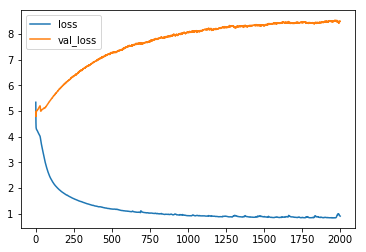

In [18]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

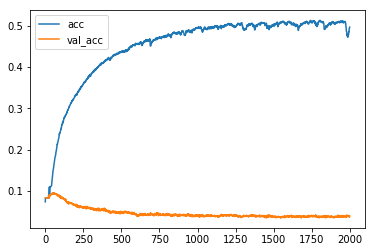

In [19]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [20]:
# make a sampling model
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [21]:
# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

In [22]:
def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)

In [23]:
# generate a 4 line poem
while True:
  for _ in range(4):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break

don't think brown ever gave up hope
nothing would have myself enough
then cane one knock!
you want a bird is a quarry -
---generate another? [Y/n]---y
look here, i know it more before you show it wish
and the birds on the name stark gathered in bow,
but won't, should hear make a leaf, if came out of the
from stumps still bleeding their house safely.'
---generate another? [Y/n]---Y
here no doubt at six pocket. i listened till this was.
toffile, were souls, but when this was your name,
yes, there's the children's house of make-believe,
to watch me.
---generate another? [Y/n]---n
